In [2]:
import os
import shutil
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def create_train_test_split():
    # Create the directory structure
    base_dir = 'DataCollecting' # update your PATH here
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create train and test directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all image files from datacollecting directory
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [
        f for f in os.listdir(base_dir)
        if f.lower().endswith(valid_extensions)
        and os.path.isfile(os.path.join(base_dir, f))
    ]

    if not image_files:
        print("No images found in datacollecting directory!")
        return

    # Split into train and test sets (80% train, 20% test)
    train_files, test_files = train_test_split(
        image_files,
        test_size=0.2,
        random_state=42
    )

    # Move files to respective directories
    for file in train_files:
        src = os.path.join(base_dir, file)
        dst = os.path.join(train_dir, file)
        shutil.copy2(src, dst)
        print(f"Copied {file} to train directory")

    for file in test_files:
        src = os.path.join(base_dir, file)
        dst = os.path.join(test_dir, file)
        shutil.copy2(src, dst)
        print(f"Copied {file} to test directory")

    # Print summary
    print("\nSplit Summary:")
    print(f"Total images: {len(image_files)}")
    print(f"Training images: {len(train_files)} ({len(train_files)/len(image_files)*100:.1f}%)")
    print(f"Testing images: {len(test_files)} ({len(test_files)/len(image_files)*100:.1f}%)")

if __name__ == "__main__":
    create_train_test_split()

Copied greenlines.jpeg to train directory
Copied redcircle.jpeg to train directory
Copied greenabstract.jpeg to train directory
Copied blueabstract.png to train directory
Copied bluerosa.jpeg to train directory
Copied bluestarfish.jpeg to train directory
Copied greenleaves.jpeg to train directory
Copied redngreencircle.jpeg to test directory
Copied bluetree.jpeg to test directory

Split Summary:
Total images: 9
Training images: 7 (77.8%)
Testing images: 2 (22.2%)


Loading training data...
Loading test data...
Training models...
Making predictions...

Model Performance:

Red Channel:
Mean Squared Error: 532.19
R² Score: 0.91

Green Channel:
Mean Squared Error: 737.12
R² Score: 0.83

Blue Channel:
Mean Squared Error: 1746.82
R² Score: -15.19


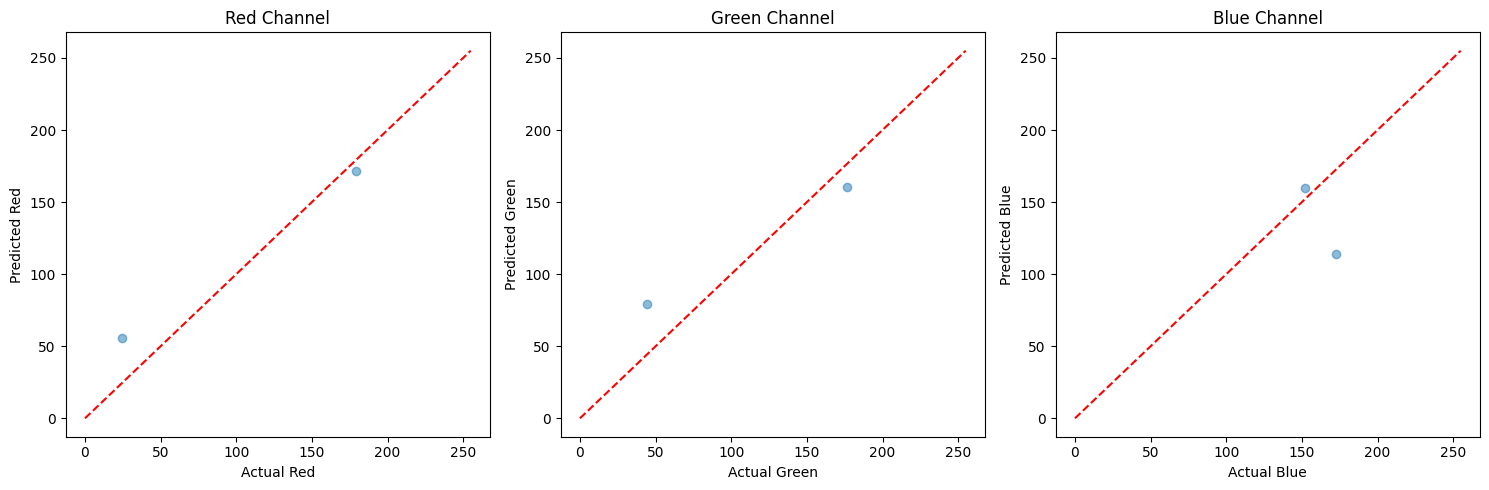

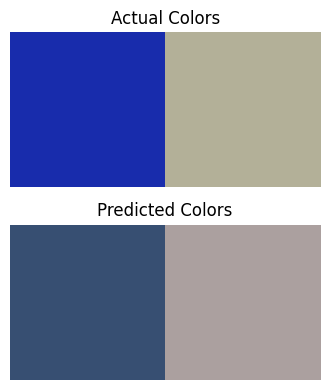

In [3]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def load_and_process_images(folder_path):
    """
    Load images and extract basic features
    """
    features = []
    rgb_values = []

    # Process each image in the folder
    for img_path in Path(folder_path).glob('*'):
        if img_path.suffix.lower() in ('.jpg', '.jpeg', '.png'):
            # Read and convert image to RGB
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize for consistency
                img_resized = cv2.resize(img, (64, 64))

                # Extract basic features
                feature_vector = [
                    np.mean(img_resized[:,:,0]),  # Mean R
                    np.mean(img_resized[:,:,1]),  # Mean G
                    np.mean(img_resized[:,:,2]),  # Mean B
                    np.std(img_resized[:,:,0]),   # Std R
                    np.std(img_resized[:,:,1]),   # Std G
                    np.std(img_resized[:,:,2]),   # Std B
                ]

                features.append(feature_vector)
                # Use mean RGB values as target
                rgb_values.append([
                    np.mean(img_resized[:,:,0]),
                    np.mean(img_resized[:,:,1]),
                    np.mean(img_resized[:,:,2])
                ])

    return np.array(features), np.array(rgb_values)

def train_model(X_train, y_train):
    """
    Train a model for each RGB channel
    """
    models = []
    for i in range(3):  # One model per RGB channel
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[:, i])
        models.append(model)
    return models

def evaluate_predictions(y_true, y_pred):
    """
    Calculate and display error metrics
    """
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    r2 = r2_score(y_true, y_pred, multioutput='raw_values')

    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        print(f'\n{channel} Channel:')
        print(f'Mean Squared Error: {mse[i]:.2f}')
        print(f'R² Score: {r2[i]:.2f}')

def visualize_results(y_true, y_pred):
    """
    Create visualization of actual vs predicted colors
    """
    # Plot actual vs predicted values for each channel
    plt.figure(figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
        plt.plot([0, 255], [0, 255], 'r--')
        plt.xlabel(f'Actual {channels[i]}')
        plt.ylabel(f'Predicted {channels[i]}')
        plt.title(f'{channels[i]} Channel')

    plt.tight_layout()
    plt.show()

    # Show actual vs predicted colors
    plt.figure(figsize=(10, 4))

    # Display actual colors
    plt.subplot(2, 1, 1)
    plt.imshow([y_true[:10]/255])  # Show first 10 samples
    plt.title('Actual Colors')
    plt.axis('off')

    # Display predicted colors
    plt.subplot(2, 1, 2)
    plt.imshow([y_pred[:10]/255])
    plt.title('Predicted Colors')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Load and process images
    print("Loading training data...")
    X_train, y_train = load_and_process_images('datacollecting/train')

    print("Loading test data...")
    X_test, y_test = load_and_process_images('datacollecting/test')

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    print("Training models...")
    models = train_model(X_train_scaled, y_train)

    # Make predictions
    print("Making predictions...")
    predictions = np.column_stack([
        model.predict(X_test_scaled) for model in models
    ])

    # Evaluate and visualize results
    print("\nModel Performance:")
    evaluate_predictions(y_test, predictions)
    visualize_results(y_test, predictions)

if __name__ == "__main__":
    main()